#### White Noise
Time series where data doesn't follow a pattern.<br>
- Unpredictable
- Conditions:
  - Constant mean $\mu$
  - Constant variance $\sigma ^2$
  - No autocorrelation 

***Autocorrelation***: How correlated a series is with past versions of itself 
$$ \rho = corr(x_t, x_{t-q})$$
No autocorrelation = no clear relation between past and present valueas of a time series.

***White Noise***: A sequence of random data, where every value has a time period assosiated with it. Note that adding noise to a model can improve it's predictions.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_theme(rc={"font.size": 23, "axes.titlesize": 23, "axes.labelsize": 22,
                  'xtick.labelsize': 15, 'ytick.labelsize': 15,})

### Loading and Transforming data

In [5]:
# Loading
directory = "C:/Users/42111/Desktop/DataScience/analysis/archive/dataScience365/3_1_index2018/Index2018.csv"
raw_data = pd.read_csv(directory).copy()

# Keep just dax stock market
dax_df = raw_data.copy()[['dax', 'date']]

# Transforming to datetime as index with b freq
dax_df['date'] = pd.to_datetime(dax_df['date'], dayfirst=True)
dax_df.set_index('date', inplace=True)
dax_df = dax_df.asfreq('b')

# Fill na's with last valid observation before the nan
dax_df = dax_df.fillna(method='ffill')
dax_df.head()

,dax
date,
1994-01-07,2224.95
1994-01-10,2225.00
1994-01-11,2228.10
1994-01-12,2182.06
1994-01-13,2142.37


#### Creating a training and testing data sets

In [6]:
size = int(len(dax_df) * 0.8) # To separate 80% of the data
df_train, df_test = dax_df.iloc[:size].copy(), dax_df.iloc[size:].copy()
df_train.head()

,dax
date,
1994-01-07,2224.95
1994-01-10,2225.00
1994-01-11,2228.10
1994-01-12,2182.06
1994-01-13,2142.37


## Generate Noise White Noise
---

First we generate an array of random values from a normal distribution.
$$ X \sim N(\mu, \sigma ^ 2) $$
Which is read as *X behaves according to a normal distribution*

In this case we need to make it comparable to the dax stock values. So we need
$$ X \sim N \left( \mu_{dax}, \sigma_{dax} ^2 \right)$$

In [7]:
wn = np.random.normal(loc=df_train['dax'].mean(),
                      scale=df_train['dax'].std(),
                      size=len(df_train))

In [8]:
df_train['wn'] = wn

In [9]:
df_train.describe()

,dax,wn
count,5021.000000,5021.000000
mean,4984.132354,4957.056858
std,1714.802821,1722.068256
min,1911.700000,-1683.310801
25%,3733.930000,3839.472133
50%,5123.500000,4979.181088
75%,6346.190000,6139.812894
max,8105.690000,11764.740534


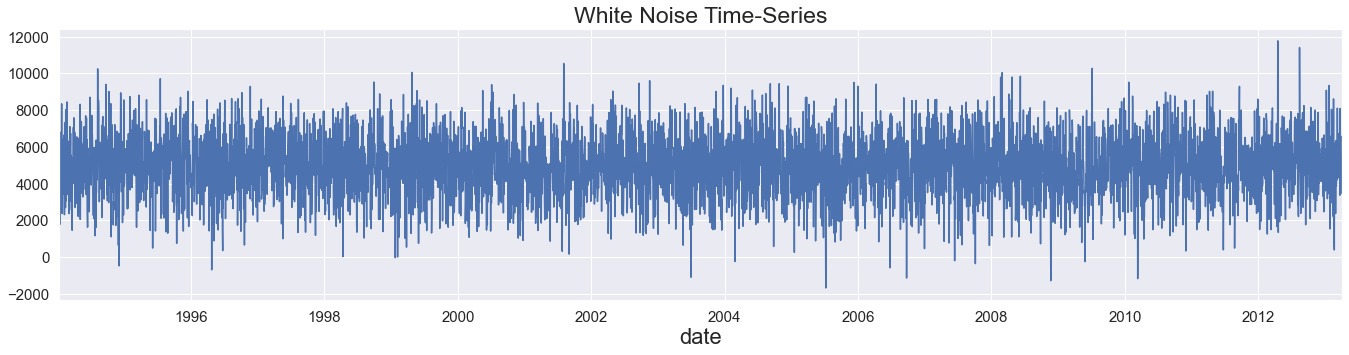

In [10]:
df_train['wn'].plot(figsize=(23,5), title='White Noise Time-Series');

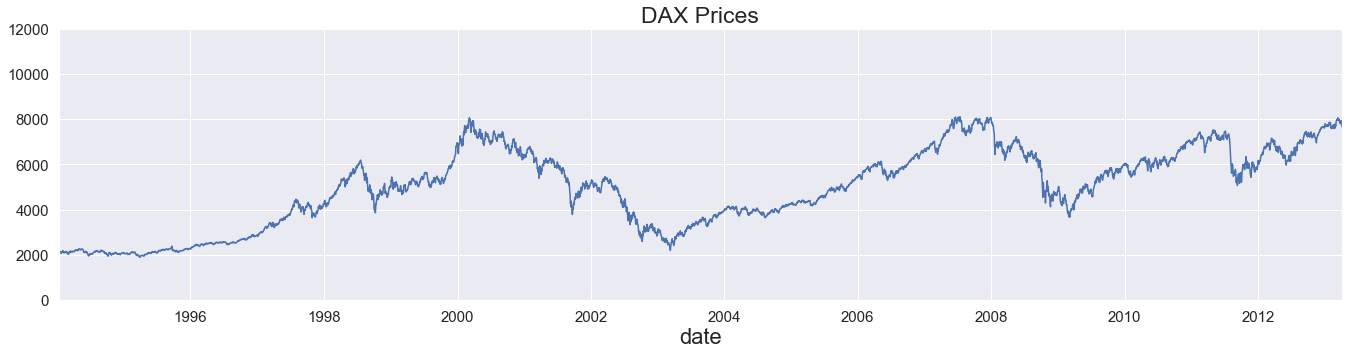

In [11]:
df_train['dax'].plot(figsize=(23, 5), title='DAX Prices', ylim=(0, 12_000));

### Random Walk
Special type of time-series, where values tend to persist over time and the **difference between periods are white noise**

In [12]:
directory = "C:/Users/42111/Desktop/DataScience/analysis/archive\
/dataScience365/5_2_randwalk-csv/RandWalk.csv"
rw = pd.read_csv(directory).copy()

# Transforming to datetime as index with b freq
rw['date'] = pd.to_datetime(rw['date'], dayfirst=True)
rw.set_index('date', inplace=True)
rw = rw.asfreq('b')

rw.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


In [13]:
df_train['rw'] = rw['price']
df_train.head()

,dax,wn,rw
date,,,
1994-01-07,2224.95,8202.251706,1122.139662
1994-01-10,2225.00,2665.920707,1080.347860
1994-01-11,2228.10,5740.883433,1082.095245
1994-01-12,2182.06,2600.261468,1083.639265
1994-01-13,2142.37,1778.283457,1067.146255


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5021 entries, 1994-01-07 to 2013-04-05
Freq: B
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dax     5021 non-null   float64
 1   wn      5021 non-null   float64
 2   rw      5021 non-null   float64
dtypes: float64(3)
memory usage: 156.9 KB


[]

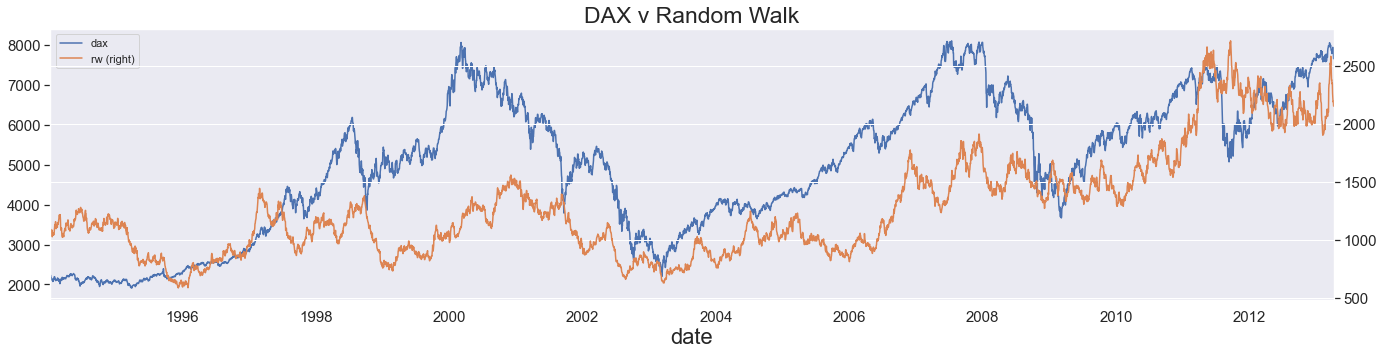

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(23,5), sharex=True)
df_train.plot(y='dax', ax=ax, sharey=False)
df_train.plot(y='rw', ax=ax, secondary_y=True, title='DAX v Random Walk')
plt.plot()

Notice that both share are somewhat alike. Both have small variations in small periods of time. Even more, both have cyclical increases and decreases in short periods of time.

***Market Efficiency***: Broadly speaking, it measures the level of difficulty in forecasting correct future values.<br>
If a given **time series resembles a random walk**, prices **can't be predicted** with great accuracy.

In addition, if future prices can be predicted with great accuaracy, there are arbitrage opportunities.<br>
***Arbitrage***: Buy and sell comodities, while the price adjust.

## Stationarity
---
***Covariance Stationarity***: implies that taking consecutive samples of data with the same size should have the same covariance regardless of the starting point.
$$Cov(S_1) = COV(S_2)$$
Properties:
- Constant mean $\mu$
- Constant variance $\sigma ^2$
- Consistent covariance with periods at an identical distance from one another.
$$ Cov(x_n, x_{n+k}) = Cov(x_m, x_{m+k})$$

Take into account that white noise has all the characteristics, since covariance it's correlation times the standard deviations $$Cov(x_n, x_{n+k}) = Corr(x_n, x_{n+k}) \sigma_1 \sigma_2 = 0$$

In the other hand, ***Strict Stationarity*** is when samples of identical size have identical distriburtions, i.e.
$$ (x_t, x_{t+k}) \sim Dist(\mu, \sigma ^2) $$
$$ (x_{t+\tau}, x_{t+\tau+k}) \sim Dist(\mu, \sigma ^2$$

But in nature, this behaviour is rarely observed, hence in analytics is accepted to refer to covariance stationarity as just simply Stationarity

## DF-test
To conduct proper time series analysis we need to determine if our data follows a stationary or non-stationary process. Dickey-Fuller test is just meant for that. 

1. Null and alternative hypothesis.
  - Null hypothesis: **Assums non-stationarity**: $H_0: \phi_1 < 1$
  - Alternative hypothesis: $H_0: \phi_1 = 1$
  - When making the test statistic, if comparing the critical value with the df-table. If it is lower, we reject the null, and assums that it comes from a stationary process.


In [45]:
test = sts.adfuller(df_train['dax'])
print(test)

(-1.520037126347776, 0.5235770028741138, 5, 5015, {'1%': -3.431654616214729, '5%': -2.862116499672828, '10%': -2.567076871409699}, 57222.3422591499)


In [52]:
print(f'test statistic to compare: {test[0]}')
print(f'Values for the DF-table: {test[4]}')
print(f'P-value associates with the test statistic: {test[1]}')
print(f'Number of lags: {test[2]}')
print(f'Number of observations used: {test[3]}')
print(f"Maximized information criteria provided \
there's some aparent correlation: {test[5]}")

test statistic to compare: -1.520037126347776
Values for the DF-table: {'1%': -3.431654616214729, '5%': -2.862116499672828, '10%': -2.567076871409699}
P-value associates with the test statistic: 0.5235770028741138
Number of lags: 5
Number of observations used: 5015
Maximized information criteria provided there's some aparent correlation: 57222.3422591499


Notice thath our test statistic score is greater than each of the critical values, thus, for all of the levels of significance we do not find sufficient proof of stationarity on the dataset.<br>
Our p-value suggest that there is a roughly 50% chance of not rejecting the null, so we can't confirm if the data is stationary.<br>
The number of lags are 5, so there is some autocorrelation going back 5 periods. We should take this into account when picking the next model.<br>
The lower the values, the easier it is to make some predictions of the future.

**Values expected** for the DF-test when making it to the **white noise**!
White noise is a stationary process, so we can expect very low p-values, there should be **no lags**, since there is no **autocorrelation**.

In [53]:
sts.adfuller(df_train['wn'])

(-71.08751283317126,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '5%': -2.8621159253018247,
  '10%': -2.5670765656497516},
 88479.02235272485)

For the random walk

In [54]:
sts.adfuller(df_train['rw'])

(-1.3286073927689717,
 0.6159849181617385,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

Again, we don't have significant evidence to say that is a stationary process, even more, we have a 60% cahnce that it does **not** comes from a non-stationary process.

In most cases, random walks intervals of the same size differ greatly, so the covariance would be very rarely be equal, hence, we espect a non-stationary process.